<h1>Vehicle Crashes in 2018</h1>
<h4>Handling missing data without dropping rows and columns</h4>

Data from [NYC OpenData website](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) modified by DataQuest.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mvc = pd.read_csv("nypd_mvc_2018.csv")

In [2]:
# Quick look at missing values
null_counts = mvc.isnull().sum()

print(null_counts)

unique_key                 0
date                       0
time                       0
borough                20646
location                3885
on_street              13961
cross_street           29249
off_street             44093
pedestrians_injured        0
cyclist_injured            0
motorist_injured           0
total_injured              1
pedestrians_killed         0
cyclist_killed             0
motorist_killed            0
total_killed               5
vehicle_1                355
vehicle_2              12262
vehicle_3              54352
vehicle_4              57158
vehicle_5              57681
cause_vehicle_1          175
cause_vehicle_2         8692
cause_vehicle_3        54134
cause_vehicle_4        57111
cause_vehicle_5        57671
dtype: int64


In [3]:
# Creating a new dataframe with null_counts and null_pct
null_pct = null_counts / mvc.shape[0] * 100

null_df = pd.DataFrame({"counts": null_counts, "%": null_pct})
print(null_df)

                     counts          %
unique_key                0   0.000000
date                      0   0.000000
time                      0   0.000000
borough               20646  35.680216
location               3885   6.714019
on_street             13961  24.127264
cross_street          29249  50.547836
off_street            44093  76.201092
pedestrians_injured       0   0.000000
cyclist_injured           0   0.000000
motorist_injured          0   0.000000
total_injured             1   0.001728
pedestrians_killed        0   0.000000
cyclist_killed            0   0.000000
motorist_killed           0   0.000000
total_killed              5   0.008641
vehicle_1               355   0.613508
vehicle_2             12262  21.191069
vehicle_3             54352  93.930596
vehicle_4             57158  98.779898
vehicle_5             57681  99.683741
cause_vehicle_1         175   0.302433
cause_vehicle_2        8692  15.021430
cause_vehicle_3       54134  93.553850
cause_vehicle_4       571

<h4>Filling and Verifying Killed and Injured Data</h4>

In [4]:
# Collect the columns that contain "killed"
killed_cols = [col for col in mvc.columns if "killed" in col]
killed = mvc[killed_cols].copy()

# Take the sum of the three columns
killed_manual_sum = killed.iloc[:,:3].sum(axis=1)
# Create a boolean mask (False if sum == total, True if sum != total)
killed_mask = killed_manual_sum != killed["total_killed"]
# Columns with missing values (where sum != total)
killed_non_eq = killed[killed_mask]

print(killed_non_eq)

       pedestrians_killed  cyclist_killed  motorist_killed  total_killed
3508                    0               0                0           NaN
20163                   0               0                0           NaN
22046                   0               0                1           0.0
48719                   0               0                0           NaN
55148                   0               0                0           NaN
55699                   0               0                0           NaN


- For 22046: the sum is less than total
- For others: total value is missing (and thereby differs from sum)

In [5]:
# Set NaN to manual_sum
killed["total_killed"] = killed["total_killed"].mask(killed["total_killed"].isnull(), killed_manual_sum)

# Set total_value for 22046 to NaN
killed["total_killed"] = killed["total_killed"].mask(killed["total_killed"] != killed_manual_sum, np.nan)

print(killed[killed_mask])

       pedestrians_killed  cyclist_killed  motorist_killed  total_killed
3508                    0               0                0           0.0
20163                   0               0                0           0.0
22046                   0               0                1           NaN
48719                   0               0                0           0.0
55148                   0               0                0           0.0
55699                   0               0                0           0.0


In [6]:
# Collect the columns that contain "injured"
injured = mvc[[col for col in mvc.columns if "injured" in col]].copy()

# Take the sum of the three columns
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)
# Create a boolean mask (False if sum == total, True if sum != total)
injured_mask = injured_manual_sum != injured["total_injured"]
# Columns with missing values (where sum != total)
injured_non_eq = injured[injured_mask]

print(injured_non_eq)

       pedestrians_injured  cyclist_injured  motorist_injured  total_injured
1222                     0                0                 1            0.0
3263                     0                0                 3            4.0
3362                     0                0                 0            1.0
3508                     0                0                 0            2.0
10989                    0                0                 0            1.0
12885                    1                0                 0            0.0
13344                    0                0                 0            1.0
15213                    0                0                 0            2.0
20163                    0                0                 0            1.0
20978                    0                0                 0            1.0
23276                    0                0                 1            0.0
24907                    1                0                 0            0.0

In [7]:
# Set NaN to manual_sum
injured["total_injured"] = injured["total_injured"].mask(injured["total_injured"].isnull(), injured_manual_sum)

# Set total_value for 22046 to NaN
injured["total_injured"] = injured["total_injured"].mask(injured["total_injured"] != injured_manual_sum, np.nan)

print(injured[injured_mask])

       pedestrians_injured  cyclist_injured  motorist_injured  total_injured
1222                     0                0                 1            NaN
3263                     0                0                 3            NaN
3362                     0                0                 0            NaN
3508                     0                0                 0            NaN
10989                    0                0                 0            NaN
12885                    1                0                 0            NaN
13344                    0                0                 0            NaN
15213                    0                0                 0            NaN
20163                    0                0                 0            NaN
20978                    0                0                 0            NaN
23276                    0                0                 1            NaN
24907                    1                0                 0            NaN

In [8]:
# Summarize count of null values before and after changes
summary = {
    "injured": [
        mvc["total_injured"].isnull().sum(),
        injured["total_injured"].isnull().sum()
    ],
    "killed": [
        mvc["total_killed"].isnull().sum(),
        killed["total_killed"].isnull().sum()
    ]
}
print(pd.DataFrame(summary, index=["before","after"]))

        injured  killed
before        1       5
after        21       1


In [9]:
# Assign changes to mvc
mvc["total_injured"] = injured["total_injured"]
mvc["total_killed"] = killed["total_killed"]

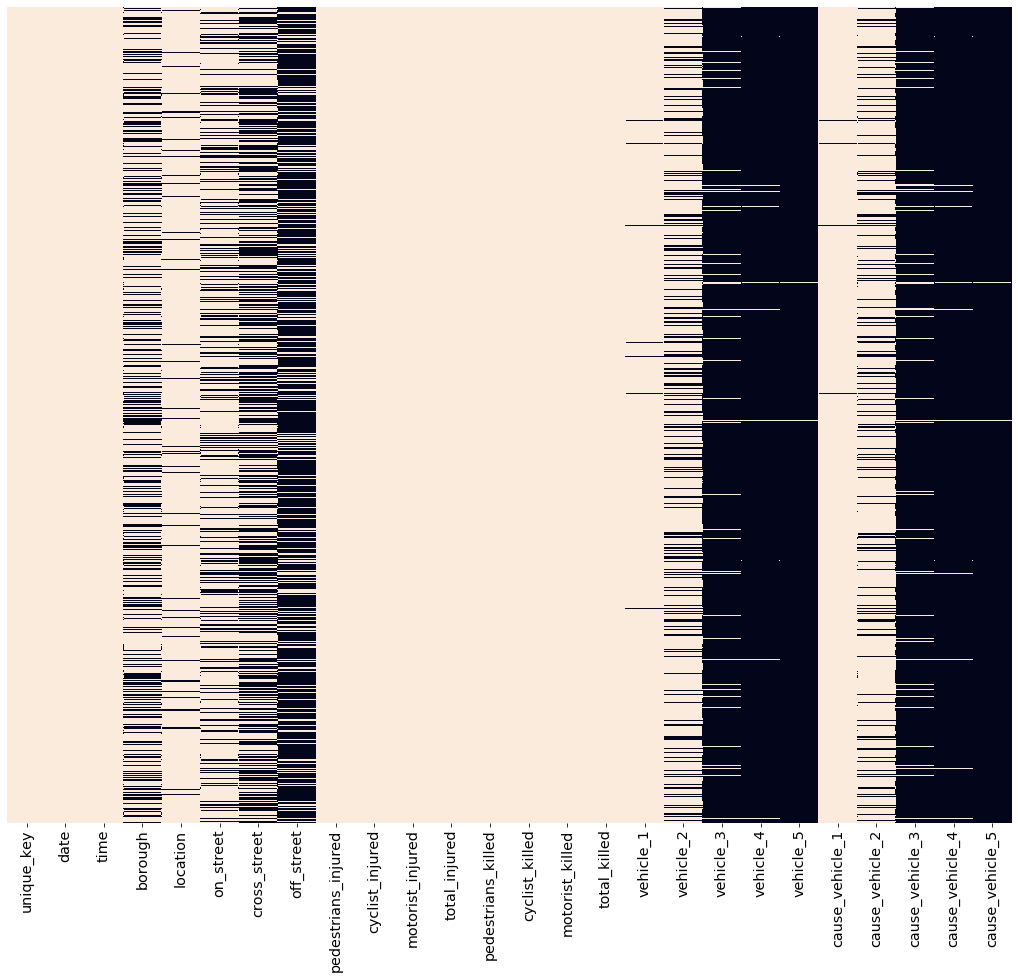

In [10]:
#Create heapmap
def plot_null_matrix(df, figsize=(18,15)):
    # Initiate the figure
    plt.figure(figsize=figsize)
    # Create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # Create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

plot_null_matrix(mvc)

- First three columns have few to no missing values
- Borough - off_street have scattered missing values
- Injury and Killed have few to no missing values
- Vehicle columns seem to break into two groups of five (same pattern)

<h4>Using Correlations between vehicle columns</h4>

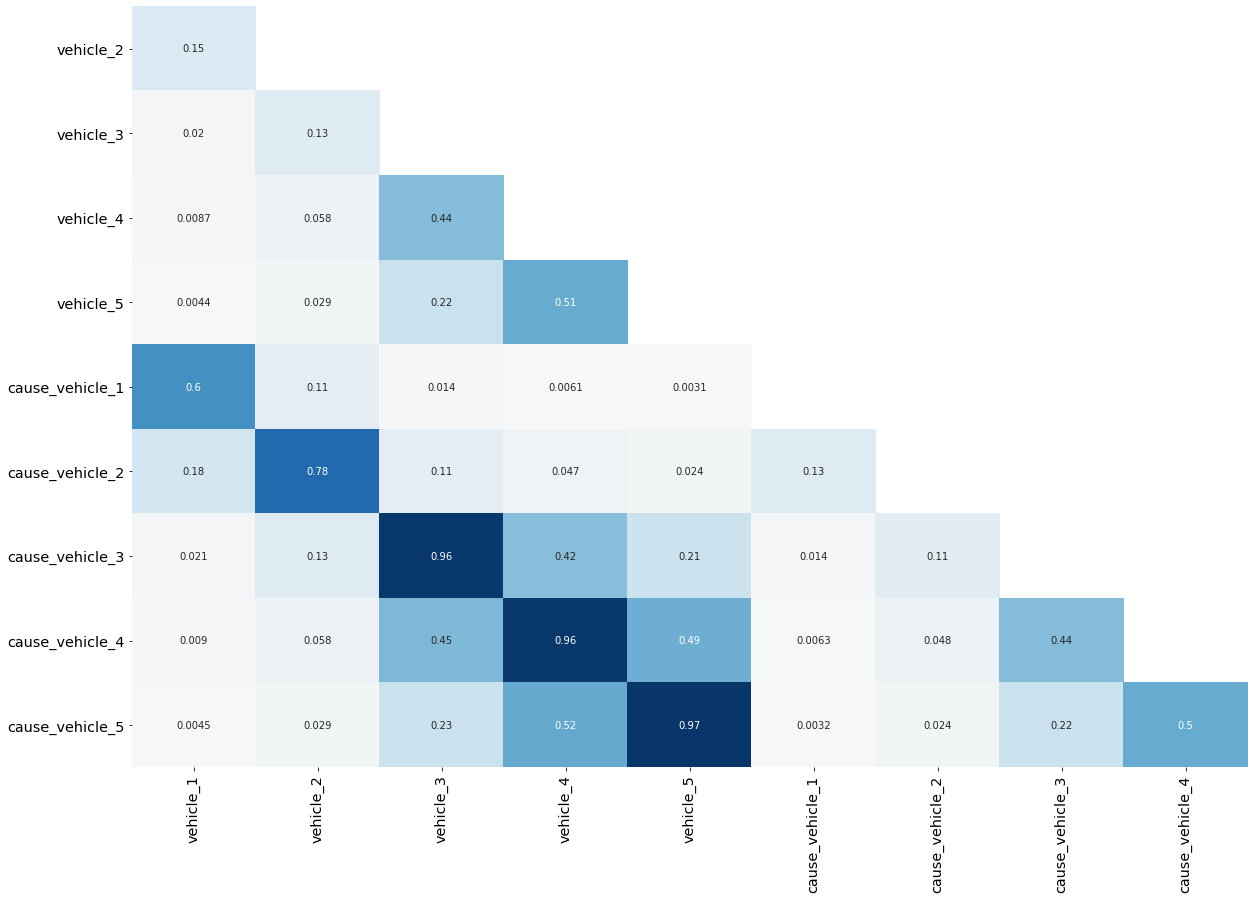

In [11]:
# Plot correlations between vehicle columns

def plot_null_correlations(df):
    # Create a correlation matrix only for columns with at least one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # Create a mask to avoid repeated values and make the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # Plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large') 
    plt.show()

# List of column names containing the substring vehicle
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

In [12]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        # Total of vehicle missing, cause isn't missing
        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        
        # Total of cause missing, vehicle isn't missing
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        # Append to list
        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)


vc_null_df = summarize_missing()

print(vc_null_df)

   vehicle_number  vehicle_missing  cause_missing
0               1              204             24
1               2             3793            223
2               3              242             24
3               4               50              3
4               5               10              0


In [13]:
# Select columns with substring cause_
cause_cols = [c for c in mvc.columns if "cause_" in c]
cause = mvc[cause_cols]
print(cause.head())

         cause_vehicle_1      cause_vehicle_2 cause_vehicle_3 cause_vehicle_4  \
0  Following Too Closely          Unspecified             NaN             NaN   
1       Backing Unsafely          Unspecified             NaN             NaN   
2  Following Too Closely          Unspecified             NaN             NaN   
3                  Glare  Passing Too Closely             NaN             NaN   
4     Turning Improperly          Unspecified             NaN             NaN   

  cause_vehicle_5  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  


In [14]:
# Stack into a single series object
cause_1d = cause.stack()
print(cause_1d.head())

0  cause_vehicle_1    Following Too Closely
   cause_vehicle_2              Unspecified
1  cause_vehicle_1         Backing Unsafely
   cause_vehicle_2              Unspecified
2  cause_vehicle_1    Following Too Closely
dtype: object


In [15]:
# Count values in single series object
cause_counts = cause_1d.value_counts()
print(cause_counts.head(10))

Unspecified                       57481
Driver Inattention/Distraction    17650
Following Too Closely              6567
Failure to Yield Right-of-Way      4566
Passing or Lane Usage Improper     3260
Passing Too Closely                3045
Backing Unsafely                   3001
Other Vehicular                    2523
Unsafe Lane Changing               2372
Turning Improperly                 1590
dtype: int64


In [16]:
# Select columns that starts with vehicle (to eliminate cause_vehicle_1)
vehicle_cols = [c for c in mvc.columns if c.startswith("vehicle")]
vehicle = mvc[vehicle_cols]
print(vehicle.head())

                             vehicle_1 vehicle_2 vehicle_3 vehicle_4 vehicle_5
0                    PASSENGER VEHICLE       NaN       NaN       NaN       NaN
1        SPORT UTILITY / STATION WAGON        DS       NaN       NaN       NaN
2  Station Wagon/Sport Utility Vehicle     Sedan       NaN       NaN       NaN
3                                Sedan     Sedan       NaN       NaN       NaN
4  Station Wagon/Sport Utility Vehicle     Sedan       NaN       NaN       NaN


In [17]:
# Stack into a single series object
vehicle_1d = vehicle.stack()
print(vehicle_1d.head())

0  vehicle_1                      PASSENGER VEHICLE
1  vehicle_1          SPORT UTILITY / STATION WAGON
   vehicle_2                                     DS
2  vehicle_1    Station Wagon/Sport Utility Vehicle
   vehicle_2                                  Sedan
dtype: object


In [18]:
# Count values in single series object
vehicle_counts = vehicle_1d.value_counts()
print(vehicle_counts.head())

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Taxi                                    3482
dtype: int64


In [19]:
# Print missing values again (to compare in next cell)

summary_before = summarize_missing()
print(summary_before)

   vehicle_number  vehicle_missing  cause_missing
0               1              204             24
1               2             3793            223
2               3              242             24
3               4               50              3
4               5               10              0


In [20]:
# For values where the vehicle is null and the cause is not-null, set the vehicle to Unspecified.
# For values where the cause is null and the vehicle is not-null, set the cause to Unspecified.

for v in range(1,6):
    v_col ="vehicle_{}".format(v)
    c_col = "cause_vehicle_{}".format(v)
    
    v_missing_mask = mvc[v_col].isnull() & mvc[c_col].notnull()
    c_missing_mask = mvc[c_col].isnull() & mvc[v_col].notnull()

    mvc[v_col] = mvc[v_col].mask(v_missing_mask, "Unspecified")
    mvc[c_col] = mvc[c_col].mask(c_missing_mask, "Unspecified")

summary_after = summarize_missing()
print(summary_after)

   vehicle_number  vehicle_missing  cause_missing
0               1                0              0
1               2                0              0
2               3                0              0
3               4                0              0
4               5                0              0


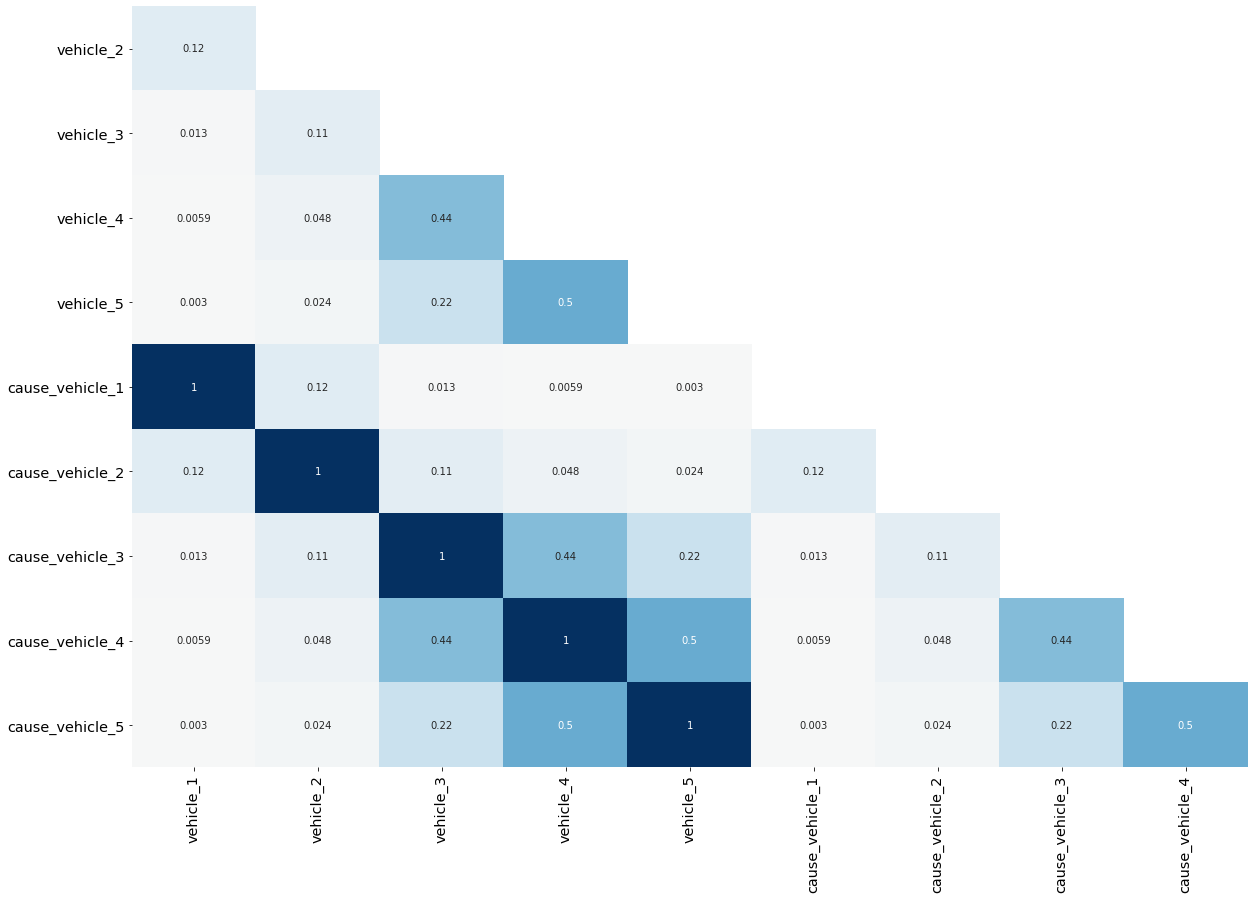

In [21]:
veh_cols = [c for c in mvc.columns if "vehicle" in c]
plot_null_correlations(mvc[veh_cols])

<h4>Missing Data in the Location Columns</h4>

In [22]:
loc_cols = ["borough", "location", "on_street", "off_street"]

location_data = mvc[loc_cols]
print(location_data.head())

     borough                location                         on_street  \
0  MANHATTAN  (40.742832, -74.00771)  WEST 15 STREET                     
1   BROOKLYN  (40.623714, -73.99314)  16 AVENUE                          
2        NaN   (40.591755, -73.9083)  BELT PARKWAY                       
3     QUEENS   (40.73602, -73.87954)  GRAND AVENUE                       
4      BRONX  (40.884727, -73.89945)                               NaN   

                                 off_street  
0                                       NaN  
1                                       NaN  
2                                       NaN  
3                                       NaN  
4  208       WEST 238 STREET                 


In [23]:
# Counts of null values in each column
null_counts = location_data.isnull().sum()

# Calculate percentage
null_pct = null_counts / mvc.shape[0] * 100

# Dataframe with counts and percentage of null values in each column
null_df = pd.DataFrame({"counts": null_counts, "%": null_pct})
print(null_df)

            counts          %
borough      20646  35.680216
location      3885   6.714019
on_street    13961  24.127264
off_street   44093  76.201092


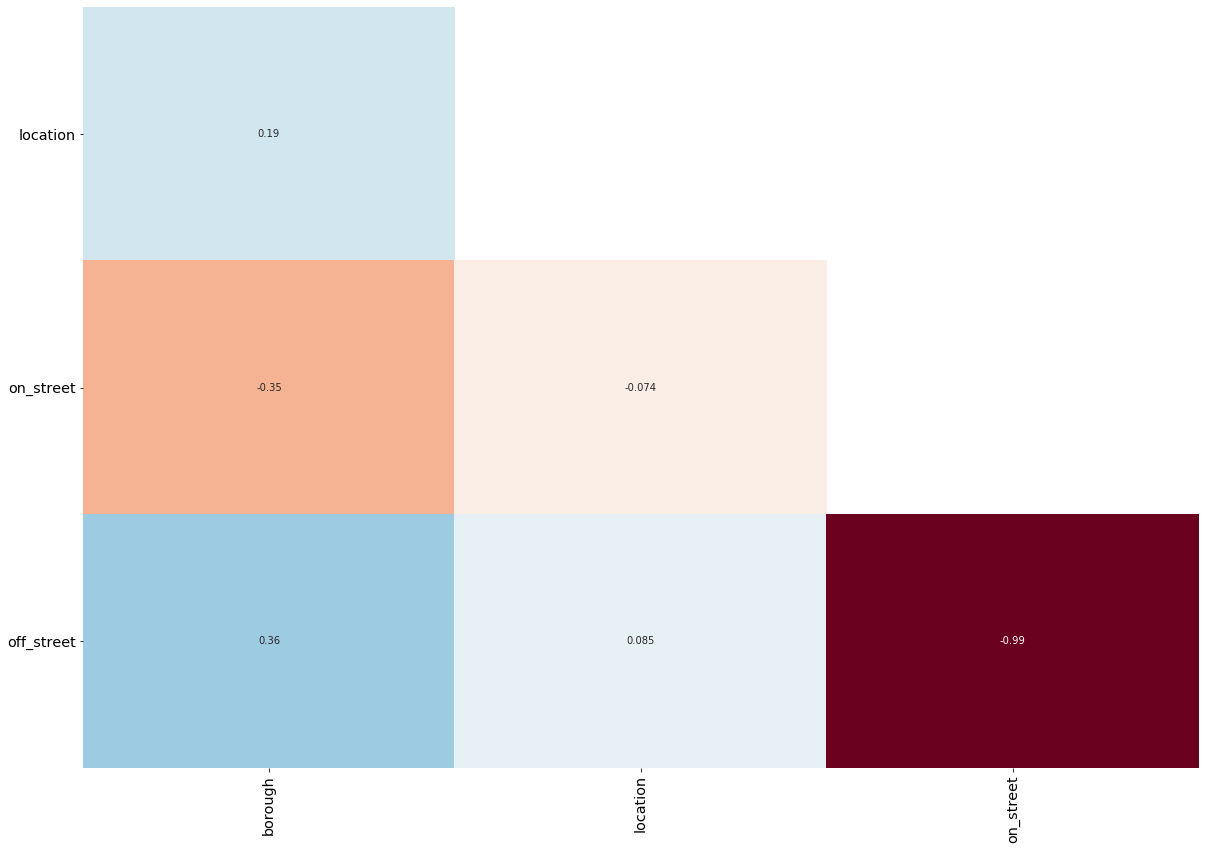

In [24]:
# Plot correlations
plot_null_correlations(location_data)

Almost no correlations, except for off_street and on_street.
There is a negative correlation, which makes sense.

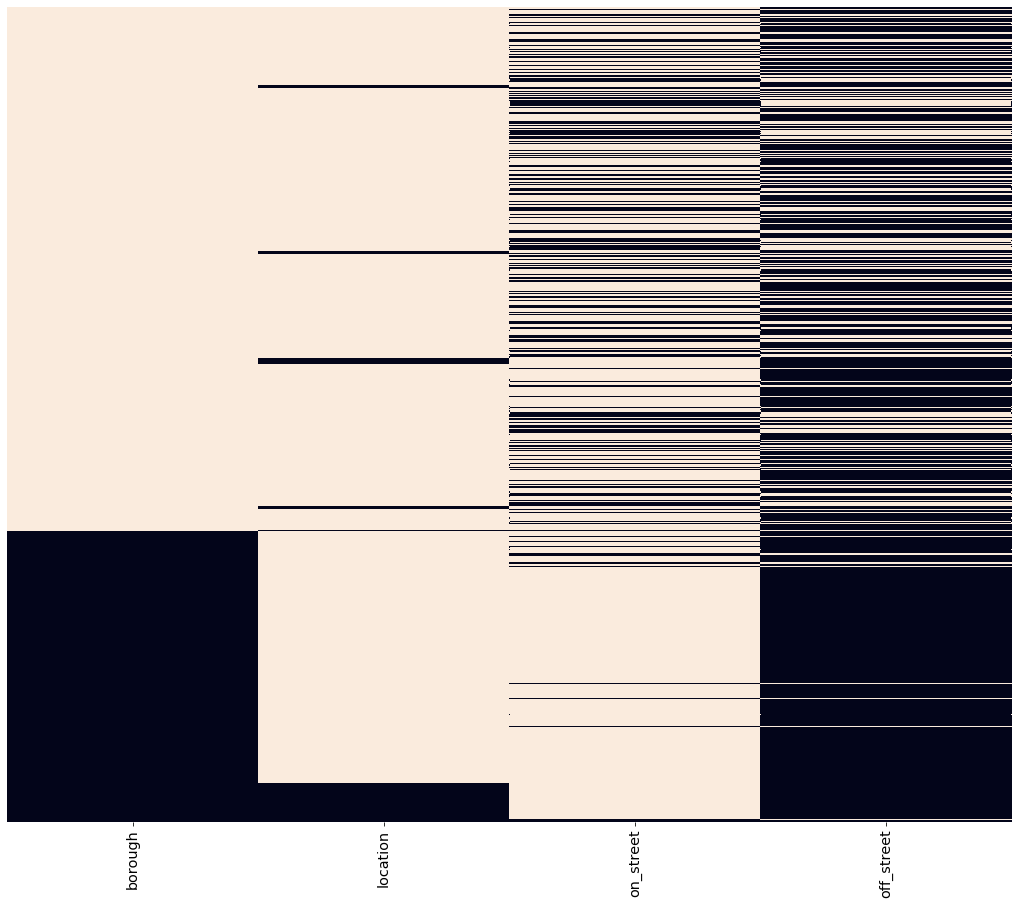

In [27]:
# Sort data first so null-values will be grouped together
sorted_location_data = location_data.sort_values(loc_cols)

plot_null_matrix(sorted_location_data)

DataQuest provided supplemental data using the GeoPy package to work with for the next cells

In [28]:
sup_data = pd.read_csv("supplemental_data.csv")
sup_data.head()

,unique_key,location,on_street,off_street,borough
0,3869058,NaN,NaN,NaN,NaN
1,3847947,NaN,NaN,NaN,NaN
2,3914294,NaN,BELT PARKWAY,NaN,BROOKLYN
3,3915069,NaN,NaN,NaN,NaN
4,3923123,NaN,NaN,NaN,NaN


In [29]:
# Check whether the unique_keys matches in data sets
mvc_keys = mvc["unique_key"]
sup_keys = sup_data["unique_key"]

is_equal = mvc_keys.equals(sup_keys)
print(is_equal)

True


In [30]:
# Impute missing values
for col in loc_cols:
    # Replace null value in mvc with value in sup_data
    mvc[col] = mvc[col].mask(mvc[col].isnull(), sup_data[col])

# Calculate new_counts and new_pct    
new_counts = mvc[loc_cols].isnull().sum()
new_pct = new_counts / mvc.shape[0] * 100

# Add to current dataframe to see the update
null_df["new_counts"] = new_counts
null_df["new_%"] = new_pct

print(null_df)

            counts          %  new_counts      new_%
borough      20646  35.680216         232   0.400940
location      3885   6.714019          77   0.133071
on_street    13961  24.127264       13734  23.734965
off_street   44093  76.201092       36131  62.441242


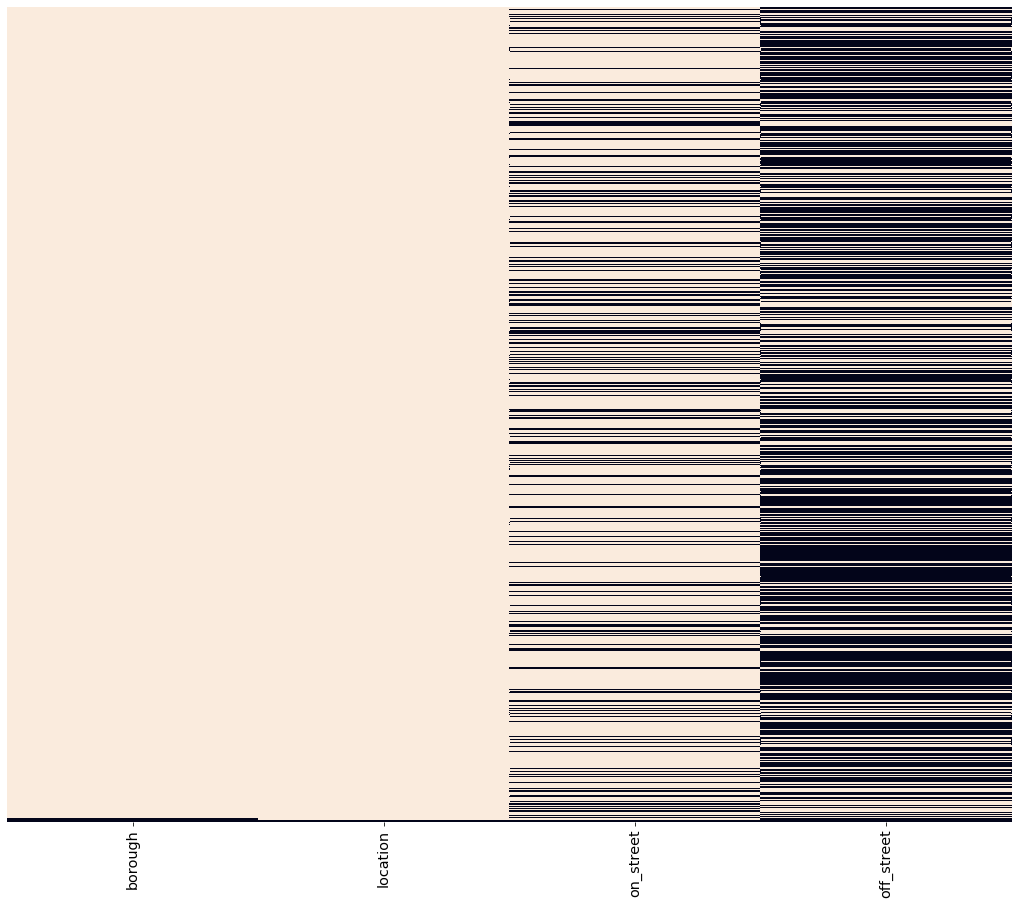

In [34]:
plot_null_matrix(sorted_location_data)